# What happens in extreme cases?

How can 15 years of observations be used to predict the magnitude of a "once every 50 years" storm? How can we build a network infrastructure capable of handling maximum traffic over a decade using only one year of data?

Extreme Value Analysis (EVA) provides a statistical and technical framework for analyzing extreme deviations from the median in probability distributions. It is employed in various fields to predict the probability of extreme anomalies recurring in the data or even the occurrence of previously unobserved phenomena.

## Introduction

We have a database that represents the outcomes of two random variables (cities and population). It is assumed that for each of these variables the outcomes are statistically independent, given that the weight of one person is not directly correlated with the weight of another person. This assumption is somewhat idealized, as in certain scenarios, individuals sharing a residence are likely to have common dietary habits. Moreover, the number of individuals in a specific city is regarded as being independent of the population of other cities. It is worth noting, however, that numerous macroeconomic, political, and social factors can influence population migration between cities. Factors such as job availability, economic opportunities, quality of life, and other societal aspects can significantly impact the mobility of individuals between various urban areas.

Our primary focus is on examining the distributional characteristics of the sum of n random variables and the maximum value among n random variables, which aligns with the domain of extreme value theory.

In [85]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

Download the datasets:
* [Cities dataset](https://simplemaps.com/data/world-cities) (choose the free one)
* [Weights dataset](https://www.kaggle.com/datasets/burnoutminer/heights-and-weights-dataset/)

In [86]:
# a list of 44691 cities with respective population
df_cities = pd.read_csv('worldcities.csv')

# a list of 25000 physical measures (height and weight) of a population of 18-year-old boys.
df_weights = pd.read_csv('Weights.csv')

In [87]:
df_cities

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629
...,...,...,...,...,...,...,...,...,...,...,...
44686,Numto,Numto,63.6667,71.3333,Russia,RU,RUS,Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra,NaN,10.0,1643985006
44687,Nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,NaN,NaN,10.0,1304217709
44688,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
44689,San Rafael,San Rafael,-16.7795,-60.6799,Bolivia,BO,BOL,Santa Cruz,NaN,NaN,1068007388


In [88]:
df_weights

,Index,Height(Inches),Weight(Pounds)
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971
...,...,...,...
24995,24996,69.50215,118.0312
24996,24997,64.54826,120.1932
24997,24998,64.69855,118.2655
24998,24999,67.52918,132.2682


In [89]:
# remove cities which population is 0 or NaN
cities_tot = np.array(df_cities.city)
pops_tot = np.array(df_cities.population)
finite = (np.isfinite(pops_tot) & (pops_tot > 0))
cities = np.copy(cities_tot[finite])
pops = np.copy(pops_tot[finite])
N_cities, N_pops = len(cities), len(pops)
print(N_cities,N_pops)

44380 44380


In [90]:
weights = np.array(df_weights['Weight(Pounds)'])
N_weights = len(weights)
print(N_weights)

25000


## Random variables analysis

Let's introduce two random variables, W and P.

W represents the weight of an 18-year-old individual. We assume that the N_weights = 25000 realizations of the random variable W are statistically independent of each other. P represents the population of a city. It is assumed that the N_pops = 44380 outcomes of the random variable P are statistically independent of each other.

First, let's utilize the datasets to analyze the probability distribution functions of the two random variables. Given the substantial number of outcomes for both random variables, we can estimate their respective distributions, with the expectation that more probable values will exhibit higher frequency within the dataset.

We will proceed by creating histograms for the outcomes of W and P, as well as their corresponding Cumulative Distribution Functions (CDFs). It is worth noting that plotting the CDFs is often more convenient than plotting the Probability Density Functions (PDFs), as the PDF can be readily derived from the CDF through its partial derivative.

OBS: A histogram is a graphical representation of a data distribution where the x-axis is divided into "bins" or "intervals." The y-axis represents the number of data points that fall into each bin. Essentially, the histogram shows how data is distributed within specific intervals.

Here's how the process of creating a histogram works:

1) Bin Division: You choose an arbitrary number of bins to divide the x-axis into. These bins should cover the entire range of the data you are analyzing.
3) Counting Occurrences: For each data point in your dataset, you check which bin it falls into. You then increment the count for the corresponding bin.
3) Graphical Representation: Once you've counted all occurrences in the bins, you graphically represent the histogram, where the x-axis shows the bins and the y-axis shows the number of data points in each bin.

The choice of the number of bins is an important step in histogram analysis. If you choose too many bins, the graph will become overly detailed, and you might have bins with few or even no data points. This makes it difficult to discern the underlying pattern in the data. On the other hand, if you choose too few bins, you may lose important details in the data distribution.

In this case we are going to take a number of bins significantly smaller that number of data.

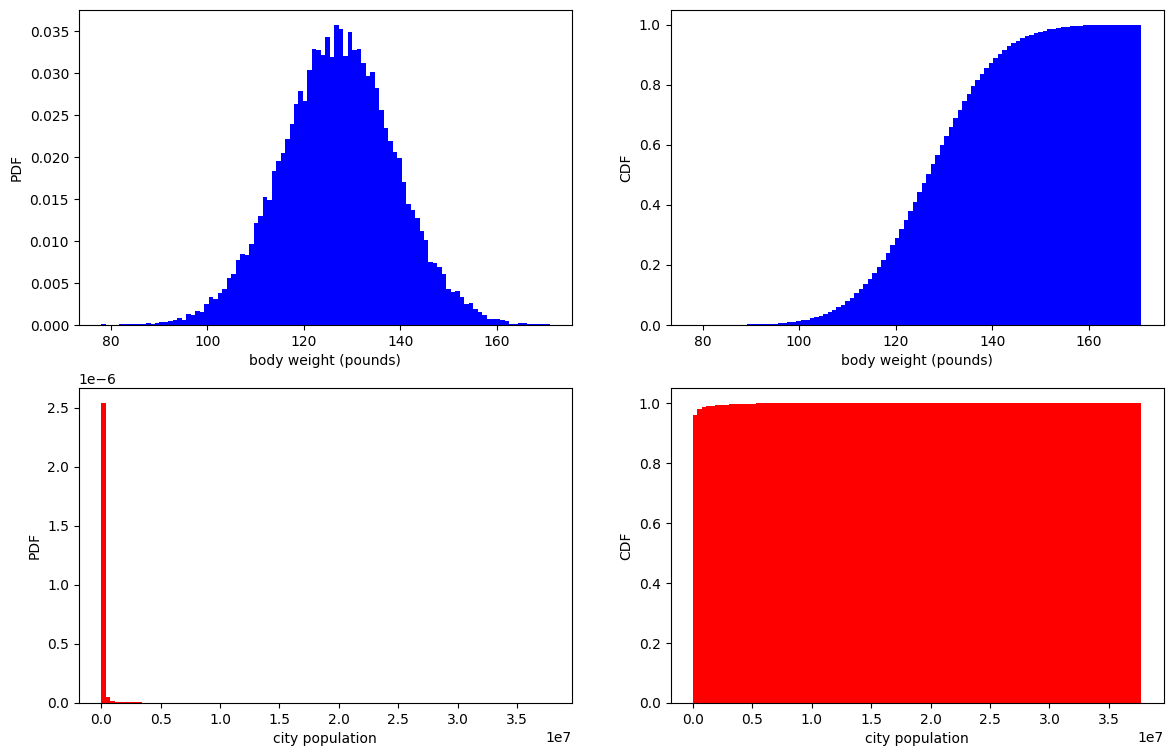

In [91]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(14,9))
n, bins, _ = ax0.hist(weights, bins=100, density = True, facecolor='blue')
ax0.set_xlabel('body weight (pounds)')
ax0.set_ylabel('PDF')

n, bins, _ = ax1.hist(weights, bins=100, density = True, facecolor='blue', cumulative=True)
ax1.set_xlabel('body weight (pounds)')
ax1.set_ylabel('CDF')

n, bins, _ = ax2.hist(pops, bins=100, density = True, facecolor='red')
ax2.set_xlabel('city population')
ax2.set_ylabel('PDF')

n, bins, _ = ax3.hist(pops, bins=100, density = True, facecolor='red', cumulative=True)
ax3.set_xlabel('city population')
ax3.set_ylabel('CDF')

plt.show()

What can be observed is that the distribution of W closely approximates a Gaussian distribution, while P is well approximated by a Pareto distribution, although this is not readily evident from the Probability Density Function (PDF) graph.

For a more comprehensive understanding of the population distribution, it is beneficial to present it in a logarithmic scale.

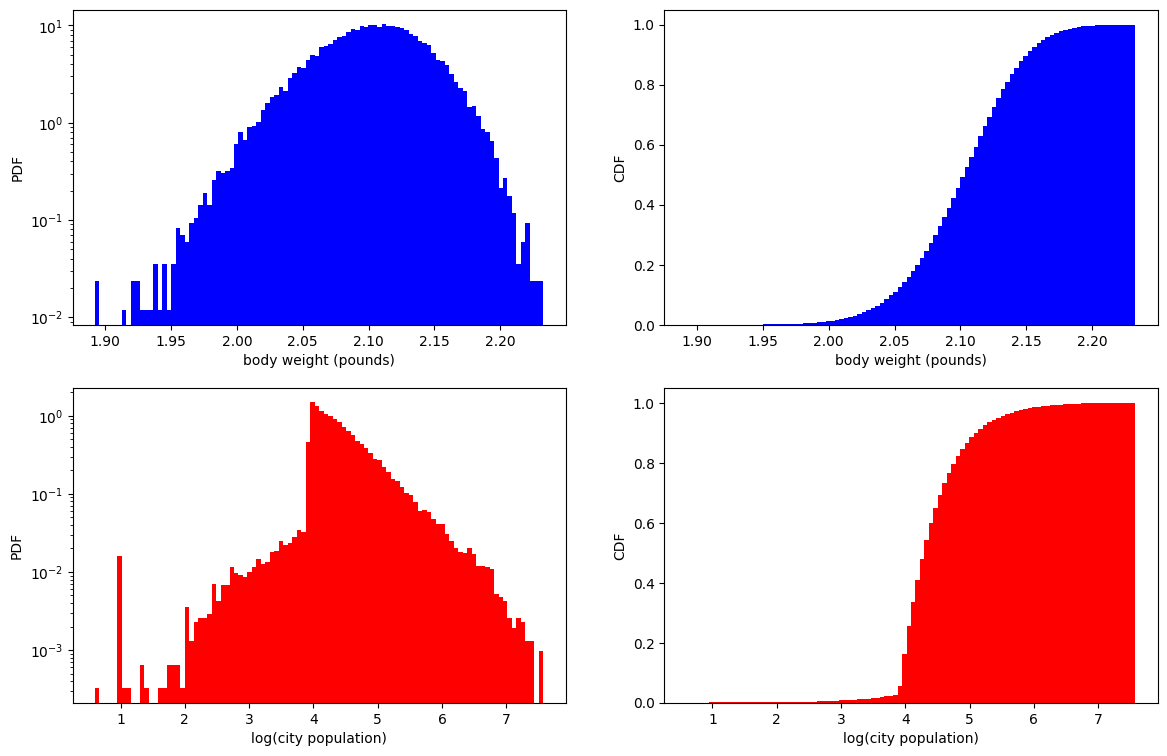

In [92]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(14,9))
n, bins, _ = ax0.hist(np.log10(weights), bins=100, density = True, facecolor='blue')
ax0.set_yscale('log')
ax0.set_xlabel('body weight (pounds)')
ax0.set_ylabel('PDF')

n, bins, _ = ax1.hist(np.log10(weights), bins=100, density = True, facecolor='blue', cumulative=True)
# ax1.set_yscale('log')
ax1.set_xlabel('body weight (pounds)')
ax1.set_ylabel('CDF')

n, bins, _ = ax2.hist(np.log10(pops), bins=100, density = True, facecolor='red')
ax2.set_yscale('log')
ax2.set_xlabel('log(city population)')
ax2.set_ylabel('PDF')

n, bins, _ = ax3.hist(np.log10(pops), bins=100, density = True, facecolor='red', cumulative=True)
# ax3.set_yscale('log')
ax3.set_xlabel('log(city population)')
ax3.set_ylabel('CDF')

plt.show()

Indeed, when the Probability Density Function (PDF) of the population is examined in a log-log scale, it appears to exhibit a linear relationship for populations exceeding 10^4 individuals (is approximately a straight line). This suggests that the data may follow a power-law distribution. In contrast, when plotting the Cumulative Distribution Function (CDF), it is advisable to employ a semi-log scale, as the Im(CDF) values fall within the range [0, 1]. 

Additionally, the PDF of the population dataset reveals an issue of imbalance. Notably, there is a "jump discontinuity" in the PDF at around x~4. This discontinuity is a result of the dataset primarily covering only capital cities and only a few small cities. Unfortunately, purchasing the professional dataset, which is available in the provided link, is not an option due to financial constraints for this analysis. This dataset imbalance can potentially lead to erroneous conclusions, especially since it suggests that cities with less than 10,000 inhabitants are considerably fewer (more that 10 times less).

Fortunately, for our specific research focus, this dataset imbalance may not be a significant concern, as our final interest primarily pertains to studying the maximum values (and not the smaller cities).

Let's attempt to estimate the probability distributions that underlie the data.

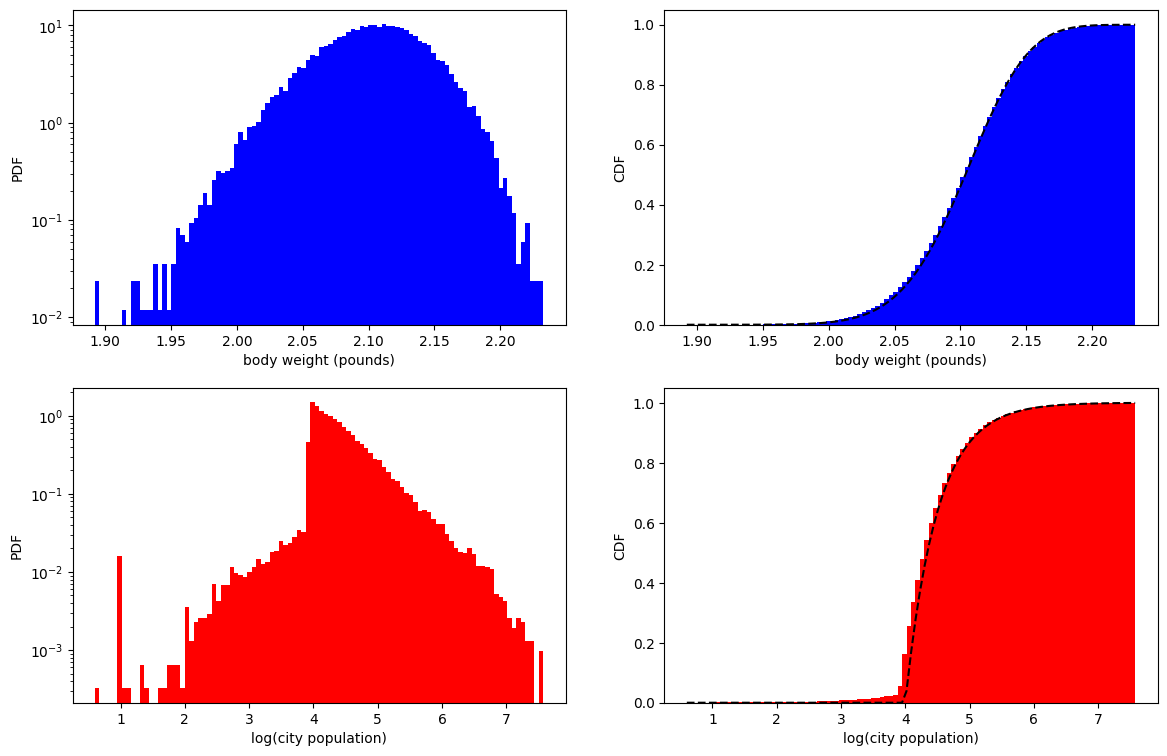

In [93]:

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(14,9))

n, bins, _ = ax0.hist(np.log10(weights), bins=100, density = True, facecolor='blue')
ax0.set_yscale('log')
ax0.set_xlabel('body weight (pounds)')
ax0.set_ylabel('PDF')

n, bins, _ = ax1.hist(np.log10(weights), bins=100, density = True, facecolor='blue', cumulative=True)
# ax1.set_yscale('log')
ax1.set_xlabel('body weight (pounds)')
ax1.set_ylabel('CDF')
ax1.plot(bins, sp.stats.norm.cdf(np.power(10,bins), loc=127, scale=11.2), '--', color ='black')

n, bins, _ = ax2.hist(np.log10(pops), bins=100, density = True, facecolor='red')
ax2.set_yscale('log')
ax2.set_xlabel('log(city population)')
ax2.set_ylabel('PDF')

n, bins, _ = ax3.hist(np.log10(pops), bins=100, density = True, facecolor='red', cumulative=True)
# ax3.set_yscale('log')
ax3.set_xlabel('log(city population)')
ax3.set_ylabel('CDF')
ax3.plot(bins, np.maximum(0.,1.-1/np.power(10,0.88*(bins-4))), '--', color ='black')


plt.show()

We now aim to estimate the expected value and standard deviation of the two random variables, W and P. We randomly sample n data points from the available dataset and observe how these estimations change with respect to n.

126.917541001001 11.278050097488244


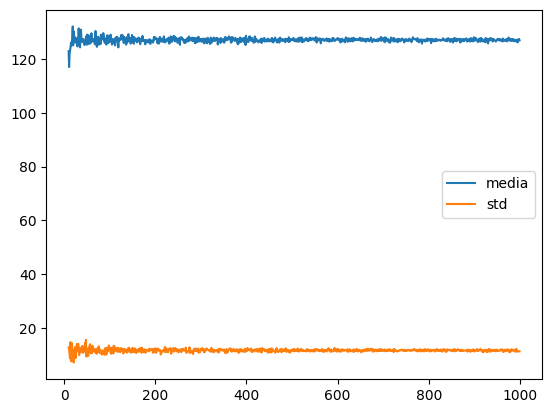

In [94]:
# for W
Ndata=N_weights
Nmin=10
Nmax=1000
ndata = np.zeros(Nmax-Nmin)
mu = np.zeros(Nmax-Nmin)
sigma = np.zeros(Nmax-Nmin)
for n in range(Nmin,Nmax):
   ndata[n-Nmin] = n
   mu[n-Nmin] = np.mean(np.random.choice(weights, n))
   sigma[n-Nmin] = np.std(np.random.choice(weights, n))
print(mu[-1],sigma[-1])
plt.plot(ndata,mu,label='media')
plt.plot(ndata,sigma,label='std')
plt.legend()
plt.show()

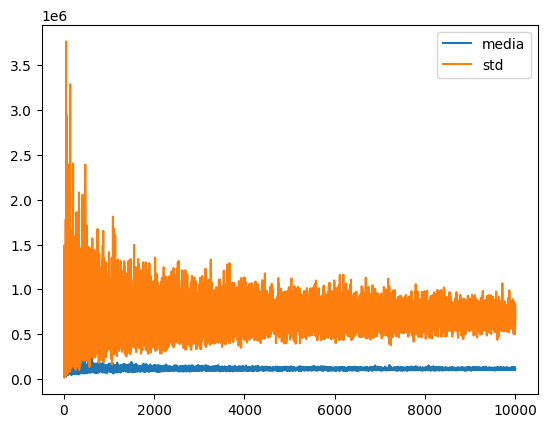

In [95]:
# for P
Ndata=N_pops
Nmin=10
Nmax=10000
ndata = np.zeros(Nmax-Nmin)
mu = np.zeros(Nmax-Nmin)
sigma = np.zeros(Nmax-Nmin)
for n in range(Nmin,Nmax):
   ndata[n-Nmin] = n
   mu[n-Nmin] = np.mean(np.random.choice(pops, n))
   sigma[n-Nmin] = np.std(np.random.choice(pops, n))
plt.plot(ndata,mu,label='media')
plt.plot(ndata,sigma,label='std')
plt.legend()
plt.show()

Our findings suggest that for the random variable W, the mean and variance converge to finite values as n increases. This leads us to conclude that the total weight of n individuals behaves in a manner approximated as [(n * mean) + (sqrt(n) * SD * N)], where N is a Gaussian random variable with a distribution of mean 0 and standard deviation 1, as the central limit theorem tell us.

However, for the random variable P, the variance exhibits continued growth, albeit at a slow pace, and the mean does not appear to stabilize. The non-stabilization of the mean, coupled with the evidence from the curve fit mentioned above, suggests that the mean may continue to increase with additional data. This behavior is likely due to the nature of the underlying distribution.

## Distribution of the sum

In this scenario, let's now consider K = 100 independent groups, each containing 100 cities/weights. The goal is to estimate the total (the sum) population/weight for each group, and you want to observe how this estimation changes as a function of the number of cities/weights in the group.

In [96]:
k=100
n=100
random_weights=np.random.choice(weights, (k,n))
random_pops=np.random.choice(pops, (k,n))

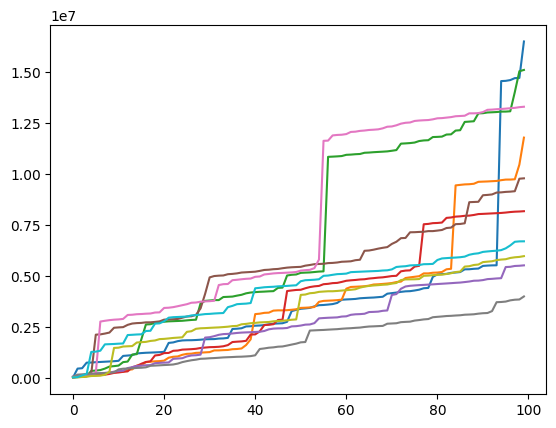

In [97]:
for i in range(10):
    plt.plot(random_pops[i,:].cumsum())
plt.show()

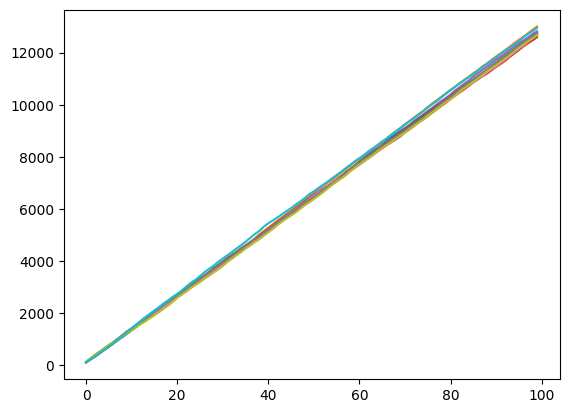

In [98]:
for i in range(10):
    plt.plot(random_weights[i,:].cumsum())
plt.show()

What you have observed is that the population fluctuations grow rapidly. This is likely because, every once in a while, a large city is added to the group, leading to a substantial increase in the total population. These fluctuations are primarily driven by rare and unlikely events, such as the addition of a large city, which has a significant impact on the overall population. This phenomenon is often associated with heavy-tailed distributions or power-law distributions, where extreme events have a disproportionate influence on the total sum, leading to pronounced fluctuations.

Indeed, the weight distribution exhibits a different behavior compared to the population distribution. In the case of weight, the curves for the different groups are relatively similar, and the addition of one person at a time results in only minor fluctuations that do not significantly impact the total weight.

This analysis has practical implications, especially for engineers designing elevators or any systems where weight capacity is a critical factor. If you consider 100 different elevators or repetitions of the same elevator event, and individuals entering one at a time until a maximum of n people are in each elevator, the relatively consistent weight distribution simplifies the design process. Engineers do not need to account for large weight fluctuations in this scenario, which allows for more accurate and efficient elevator capacity planning.

In contrast, if people's weight were distributed similarly to the population of cities, it would require a much more cautious approach with a significant margin of safety to accommodate the potential for substantial weight variations, ensuring the safety and functionality of the elevator system.

## Extreme values distribution

Let's now take the maximum of a fixed set of n values, and this constitutes a random variable. Repeat this process multiple times (many times), resulting in a set of maximum values. Now, create a histogram and calculate the mean and standard deviation of the maximum value distribution.

In [99]:
max_weights=np.max(random_weights, axis=1)
max_pops=np.max(random_pops, axis=1)

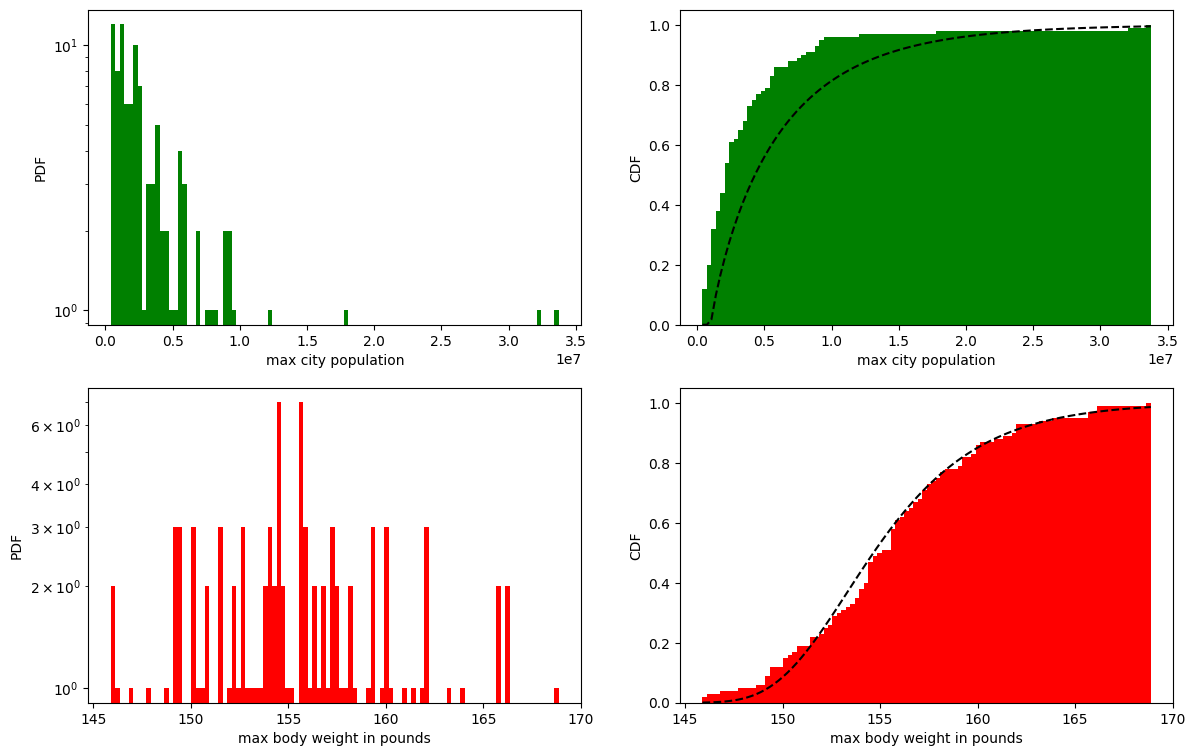

In [100]:
fig, ((ax0, ax2), (ax1, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(14,9))

n, bins, patches = ax0.hist(max_pops, bins=100, facecolor='green');
ax0.set_yscale('log')
ax0.set_xlabel('max city population')
ax0.set_ylabel('PDF')

n, bins, patches = ax1.hist(max_weights, bins=100, facecolor='red');
ax1.set_yscale('log')
ax1.set_xlabel('max body weight in pounds')
ax1.set_ylabel('PDF')

n, bins, patches = ax2.hist(max_pops, bins=100, facecolor='green',density=True,cumulative=True);
ax2.set_xlabel('max city population')
ax2.set_ylabel('CDF')
ax2.plot(bins, sp.stats.weibull_min.cdf(bins, 0.88, loc=1e6, scale=.5e7), '--', color ='black')

n, bins, patches = ax3.hist(max_weights, bins=100, facecolor='red',density=True,cumulative=True);
ax3.set_xlabel('max body weight in pounds')
ax3.set_ylabel('CDF')
ax3.plot(bins, sp.stats.gumbel_r.cdf(bins, loc=np.mean(max_weights)-0.577*np.sqrt(6.)/3.14*np.std(max_weights), scale=np.sqrt(6.)/3.14*np.std(max_weights)), '--', color ='black')

plt.show()

We infer that the distribution of the maximum value for the population is well-defined by the Frechét distribution, while the distribution of the maximum value for weight is well-defined by the Gumbel distribution.

The graphs indicate that as n becomes large, the maximum values are distributed as follows:
Weight: Gumbel
Population: Frechét

An analysis of this type, in practical terms, allows us to estimate the probability of the maximum value deviating significantly from our expected value. This has utility across a wide range of applications, from financial to hydrologic (refer to the README.txt for more details). In the case of a Gumbel distribution, this probability is very small, while in the case of a Frechét distribution, the tails of the distribution are more pronounced, resulting in a higher probability.

The purpose of this entire analysis is to provide an estimation of the probability of a rare event occurring, estimating what the typical maximum value is and the probability that in the future the maximum value fluctuates significantly from our expectations.